Identifying Fraudulent Activities
==================
Goal
----
The goal is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent (Fraud_Data.csv). You only have the user first transaction on the site and you have to make your classification ("fraud/no fraud"). 
Tasks
-----
1. For each user, determine the country based on the numeric IP address. (IpAddress_to_Country.csv)

2. Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model. 

3. Explain how the model is making predictions from a user perspective. What kinds of users are more likely to be classified as at risk?  

4. How would you use the model which can predict fraudulent activities in real time?  

In [1]:
import pandas as pd
import pandasql
import numpy as np

df_fraud=pd.read_csv('Fraud_Data.csv',low_memory=False)

In [2]:
print "Number of total users:\t",len(df_fraud)

Number of total users:	151112


There is no NaN in this dataset. 
Create new features
-------------------------------

**Time difference** between sign-up time and purchase time (shorter, more suspicious)

If many different user_id using the same device_id, more suspicious

If many different user_id using the same ip_address, more suspicious


In [3]:
#check number of fraud (class=1) 
q="""
SELECT class,count(class)
FROM df_fraud
GROUP BY class;
"""
sol4=pandasql.sqldf(q.lower(),locals())
print "Fraction of fraud (class=1): \t",(352./(352.+3648.))
sol4.head()

Fraction of fraud (class=1): 	0.088


,class,count(class)
0,0,136961
1,1,14151


In [4]:
#convert a string into a timestamp
df_fraud['signup_time']=df_fraud['signup_time'].astype('datetime64[ns]')
df_fraud['purchase_time']=df_fraud['purchase_time'].astype('datetime64[ns]')
#add a new feature 'time_difference'
df_fraud['time_difference']=df_fraud['purchase_time'] - df_fraud['signup_time']

#add a new feature 'time_float'
time_float=[]
for t in list(df_fraud['time_difference']):
    tf=t.total_seconds()
    time_float.append(tf)
    
td=pd.DataFrame({'time_float':pd.Series(time_float)})
df_fraud['time_float']=td['time_float']

df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_difference,time_float
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,52 days 03:51:22,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,0 days 04:59:04,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,0 days 00:00:01,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,5 days 16:41:25,492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,50 days 11:31:01,4361461.0


In [5]:
#check for number of different user_id sharing same device_id 
q="""
SELECT device_id,COUNT(user_id)
FROM df_fraud
GROUP BY device_id;
"""

sol3=pandasql.sqldf(q.lower(),locals())
print "Maximum number of users sharing the same device_id:\t",sol3['count(user_id)'].max()
print "Number of unique device_id:\t",len(sol3)

Maximum number of users sharing the same device_id:	20
Number of unique device_id:	137956


/Users/anw4/anaconda/lib/python2.7/site-packages/pandasql/sqldf.py:58: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  write_table(env[table_name], table_name, conn)


In [6]:
#check for number of different user_id sharing same ip_address
q="""
SELECT ip_address,COUNT(user_id)
FROM df_fraud
GROUP BY ip_address;
"""

sol5=pandasql.sqldf(q.lower(),locals())
print "Maximum number of users sharing the same ip_address:\t",sol5['count(user_id)'].max()
print "Number of unique ip_address:\t",len(sol5)

Maximum number of users sharing the same ip_address:	20
Number of unique ip_address:	143512


Maximum number of user_ids sharing the same ip_address or device_ids are 20, which is very suspicious number so I assume that number of user_ids sharing the same ip_address or device_ids will be important features. 

In [7]:
import time
share_device=sol3.sort_values('count(user_id)',ascending=0)
share_device.rename(columns={'count(user_id)':'share_device'},inplace=True)
q="""
SELECT *  
FROM df_fraud
JOIN share_device
ON share_device.device_id=df_fraud.device_id
"""
t1=time.time()
sol13=pandasql.sqldf(q.lower(),locals())
t2=time.time()
#print "time:\t",(t2-t1)

#sol13.describe()
sol13.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_difference,time_float,device_id,share_device
0,22058,2015-02-24 22:55:49.000000,2015-04-18 02:47:11.000000,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,4506682000000000,4506682.0,QVPSPJUOCKZAR,1
1,333320,2015-06-07 20:39:50.000000,2015-06-08 01:38:54.000000,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,17944000000000,17944.0,EOGFQPIZPYXFZ,1
2,1359,2015-01-01 18:52:44.000000,2015-01-01 18:52:45.000000,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,1000000000,1.0,YSSKYOSJHPPLJ,12
3,150084,2015-04-28 21:13:25.000000,2015-05-04 13:54:50.000000,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,492085000000000,492085.0,ATGTXKYKUDUQN,1
4,221365,2015-07-21 07:09:52.000000,2015-09-09 18:40:53.000000,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,4361461000000000,4361461.0,NAUITBZFJKHWW,1


In [8]:
share_ip=sol5.sort_values('count(user_id)',ascending=0)
share_ip.rename(columns={'count(user_id)':'share_ip','ip_address':'ip_address2'},inplace=True)
q="""
SELECT *  
FROM sol13
JOIN share_ip
ON share_ip.ip_address2=sol13.ip_address
"""
sol15=pandasql.sqldf(q.lower(),locals())
sol15.head()
#sol15.describe()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,time_difference,time_float,share_device,ip_address2,share_ip
0,22058,2015-02-24 22:55:49.000000,2015-04-18 02:47:11.000000,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,4506682000000000,4506682.0,1,7.327584e+08,1
1,333320,2015-06-07 20:39:50.000000,2015-06-08 01:38:54.000000,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,17944000000000,17944.0,1,3.503114e+08,1
2,1359,2015-01-01 18:52:44.000000,2015-01-01 18:52:45.000000,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,1000000000,1.0,12,2.621474e+09,12
3,150084,2015-04-28 21:13:25.000000,2015-05-04 13:54:50.000000,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,492085000000000,492085.0,1,3.840542e+09,1
4,221365,2015-07-21 07:09:52.000000,2015-09-09 18:40:53.000000,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,4361461000000000,4361461.0,1,4.155831e+08,1


Deal with categorical data
------------------------
We first check number of categories in ['source','browser'].

Then we deal with categorical data ['source','browser','sex'] using dummy variables. 

In [9]:
dummies_sex=pd.get_dummies(sol15['sex'],prefix='sex')
dummies_source=pd.get_dummies(sol15['source'],prefix='source')
dummies_browser=pd.get_dummies(sol15['browser'],prefix='browser')

sol9=pd.concat([sol15,dummies_sex,dummies_source,dummies_browser],axis=1)
sol10=sol9.drop(['sex','source','browser','user_id','signup_time','purchase_time','device_id','ip_address','time_difference','ip_address2'],axis=1)
sol10.head()

,purchase_value,age,class,time_float,share_device,share_ip,sex_F,sex_M,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,34,39,0,4506682.0,1,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,16,53,0,17944.0,1,1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,15,53,1,1.0,12,12,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,44,41,0,492085.0,1,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,39,45,0,4361461.0,1,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Feature Selection
----------------
I will look at the correlation of each feature agains 'class'. 
Based on our data types, I will use the following algorithms:
1. Phi correlation for nominal (class) vs. nominal (source,browser,sex) data 
 http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
2. Point-Biserial correlation for nominal (class) vs. quantitative data (purchase_value,age,time_diff)
REF:   https://www.andrews.edu/~calkins/math/edrm611/edrm13.htm

In [10]:
from scipy.stats import pointbiserialr
from sklearn.metrics import matthews_corrcoef

columns=sol10.columns.values
param=[]
correlation=[]
abs_corr=[]
for c in columns:
    if len(sol10[c].unique())<=2:
        corr=matthews_corrcoef(sol10['class'],sol10[c]) #phi coefficient
    else:
        corr=pointbiserialr(sol10['class'],sol10[c])[0]
    param.append(c)
    correlation.append(corr)
    abs_corr.append(abs(corr))
    
    
#Create dataframe for visualization
param_df=pd.DataFrame({'correlation':correlation,'parameter':param,'abs_corr':abs_corr})
#Sort by absolute correlation
param_df=param_df.sort(['abs_corr'],ascending=False)
#Set parameter name as index
param_df=param_df.set_index('parameter')
param_df.head(n=10)

/Users/anw4/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,abs_corr,correlation
parameter,,
class,1.000000,1.000000
share_device,0.670837,0.670837
share_ip,0.658625,0.658625
time_float,0.257888,-0.257888
source_Direct,0.020285,0.020285
browser_Chrome,0.014620,0.014620
browser_IE,0.013363,-0.013363
source_SEO,0.012251,-0.012251
sex_M,0.007639,0.007639


The absolute correlation coefficients of 'share_device','share_ip','time_float'are above 0.25. Therefore, these features are more important.

Features visualization
--------------------
DrawScatter for quantitative features

/Users/anw4/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


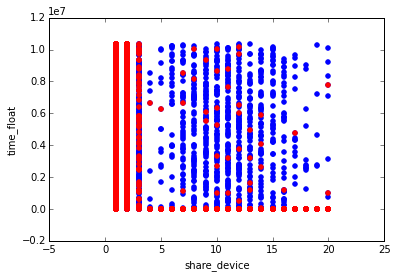

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
qfeatures=['class','share_device','time_float','share_ip','purchase_value','age'] 
nfeatures=['class','source_Direct','source_SEO','browser_FireFox','source_Ads','browser_Opera','browser_Safari','sex_F','sex_M','browser_IE','browser_Chrome']
def DrawScatter(df,qfeatures):
    n=len(df)
    X=df[qfeatures[1]]
    Y=df[qfeatures[2]]
    fr_i=np.nonzero(df[qfeatures[0]])[0]
    plt.scatter(X,Y,color='blue')
    plt.scatter(X[fr_i],Y[fr_i],color='red') #if fraud, label red
    
    plt.xlabel(qfeatures[1])
    plt.ylabel(qfeatures[2])
    plt.show()
    
DrawScatter(sol10,qfeatures)


Try Random Forest Classifier
----------------------


In [18]:
labels=sol10['class'].copy(deep=True).astype(int).as_matrix()
features=sol10.drop('class',axis=1).copy(deep=True).as_matrix() #try everything first
from sklearn.cross_validation import train_test_split
features_train,features_test,labels_train,labels_test=train_test_split(features,labels,test_size=0.5,random_state=0) 

**Plot ROC curve**

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import metrics 
lr_clf=LogisticRegression()
rf_clf=RandomForestClassifier()

lr_y_score=lr_clf.fit(features_train,labels_train).predict_proba(features_test)[:,1]
rf_y_score=rf_clf.fit(features_train,labels_train).predict_proba(features_test)[:,1]

In [40]:
print lr_y_score[:10]
print rf_y_score[:10]

[ 0.00807385  0.21868214  0.00792764  0.00396751  0.09102805  0.40484717
  0.49999986  0.00717654  0.16753132  0.01880238]
[ 0.   0.   0.2  0.5  0.   0.   1.   0.   0.1  0. ]


In [41]:
#Compute ROC curve and ROC area for each class
lr_fpr, lr_tpr, _ = metrics.roc_curve(labels_test, lr_y_score)
lr_roc_auc = metrics.auc(lr_fpr, lr_tpr)
rf_fpr,rf_tpr,_= metrics.roc_curve(labels_test, rf_y_score)
rf_roc_auc = metrics.auc(rf_fpr, rf_tpr)

In [42]:
lr_pred=lr_clf.fit(features_train,labels_train).predict(features_test)
lr_accuracy=lr_clf.score(features_test,labels_test)
rf_pred=rf_clf.fit(features_train,labels_train).predict(features_test)
rf_accuracy=rf_clf.score(features_test,labels_test)

In [43]:
lr_precision=metrics.precision_score(labels_test,lr_pred)
lr_recall=metrics.recall_score(labels_test,lr_pred)
print "Precision of Logistic Regression:",lr_precision
print "Recall of Logistic Regression:",lr_recall
rf_precision=metrics.precision_score(labels_test,rf_pred)
rf_recall=metrics.recall_score(labels_test,rf_pred)
print "Precision of Random Forest:",rf_precision
print "Recall of Random Forest:",rf_recall

Precision of Logistic Regression: 0.0
Recall of Logistic Regression: 0.0
Precision of Random Forest: 0.922284644195
Recall of Random Forest: 0.558390022676


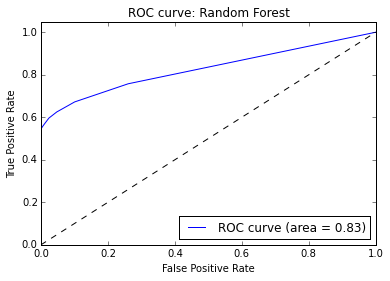

In [45]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(rf_fpr, rf_tpr, label='ROC curve (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: Random Forest')
plt.legend(loc="lower right")
plt.show()
